# In which I reiterate how important it is to generate a proper appreciation for Iterators and Generators. 

If you have done any Python at all you've probably come across the concepts *iterator* and *generator*, they sound a little intimidating but are actually very cuddly. This post tries to clearly define these (and related) terms, and also show you how and when to use these guys. We'll start with iterator stuff, and end with generator stuff.

As always:

In [249]:
import numpy as np
import matplotlib.pyplot as plt
import itertools as it

# Container vs. Iterator vs. Iterable
Unfortunately these terms are thrown around very sloppily, so first let's clear up the syntax. To summarize an [excellent blog post by Vincent Driessen](nsnvie.com/posts/iterators-vs-generators/):

- a **container** is any object that holds stuff and can be asked if it *contains* a certain element (think `dict`, `list`, `set`).
- an **`iterator`** is any object that remembers its state so it can produce the next value in a sequence when `next()` is called on it.
- an **iterable** is any object that can produce an `iterator` when `iter()` is called on it (most containers are iterable).

Some examples are in order at this point.

**We can ask the `list` if it "contains" a certain element thus a `list` is a container!**

In [143]:
li = [1, 2, 3]
2 in li

True

**We can make an `iterator` object by calling `iter()` on the list, thus the list is an iterable!** 

In [144]:
li_itr = iter(li) 
type(li_itr)

list_iterator

**We can call `next()` on `li_it`, thus we confirm that `li_it` really is an iterator.**

In [145]:
next(li_itr), next(li_itr)

(1, 2)

# Fun with Iterators
What makes an object an `iterator` is having a defined behavior under the built-in `next()`. Each call of `next()` will return the next element of the iterator, starting with the first element and ending with raising an exception after all the elements have been pulled.

## `for` Loops 
Think you've never used an iterator? Wrong, you've been using them like crazy. The `for` syntax that lets us loop with ease through container objects is secretly using the iterator protocol. This:

In [146]:
li = [1, 2, 3]
for elem in li:
    print(elem)

1
2
3


is actually implemented kinda like this:

In [147]:
itr = iter(li)
while True:
    try:
        print(next(itr))
    except StopIteration:
        break

1
2
3


In python, you can call `iter()` on most container objects to get their equivalent `iterator`. Some maybe less obvious examples are:

In [148]:
dict_itr = iter({'one':1, 'two':2}) 
next(dict_itr)

'two'

In [149]:
str_itr = iter("alohamora")
next(str_itr)

'a'

## Itertools Module
The `itertools` module of the standard library implements many different kinds of useful `iterators` and iterator-centric functionality - I want to highlight some of the most useful stuff. I like to use the import name `it`, but I don't know if that's a very common convention.

### Count indefinitely from some number by some increment with `count()`

In [47]:
cnt = it.count(start=3.26, step=0.2)
next(cnt), next(cnt)

(3.26, 3.46)

### Cycle indefinitely through a finite list with `cycle()`.

In [48]:
cyc = it.cycle(["a", "b"])
next(cyc), next(cyc), next(cyc)

('a', 'b', 'a')

### Chain iterators together with `chain()`.

In [138]:
itr1 = iter("ab")
itr2 = iter([1, 2])
itr_chain = it.chain(itr1, itr2)

In [139]:
next(itr_chain), next(itr_chain), next(itr_chain)

('a', 'b', 1)

### Slice an iterator with `islice()`!
Normally iterators don't support the slice sytnax, but itertools `islice` implements this!

In [119]:
cnt = it.count(start=0.5, step=1)
cnt_slc = it.islice(cnt, 3, 6)

In [120]:
for elem in cnt_slc:
    print(elem)

3.5
4.5
5.5


You can also check out:
- the [full itertools docs](https://docs.python.org/2/library/itertools.html).
- a great [intro to itertools by Justin Duke](http://jmduke.com/posts/a-gentle-introduction-to-itertools/)

## Making Your Own Iterators (skip this if you never use classes)
We can make our own classes which are iterators simply by exposing methods `__next__` and `__iter__`. Calling `next()` on these guys will cause Python to search the class for a `__next__` method. Lets make a class that defines objects who iterate through the integers:

In [45]:
class int_iter:
    def __init__(self, start_int):
        self.curr_value = start_int
    
    def __iter__(self):
        return self
    
    def __next__(self):
        temp = self.curr_value
        self.curr_value += 1  # Update this attribute to the next integer value
        return temp  # Return the previous "current value"

In [46]:
my_it = int_iter(10)
next(my_it), next(my_it)

(10, 11)

# Generators
Now that you know about iterators, you're in a position to understand generators. Sadly here there is an even more ambiguous usage of terms, so let me straighten out the syntax first:

- a **generator iterator** is an object that can temporarily freeze it's execution, but later pick up exactly where it left-off. It is a true python `iterator`!
- a **generator function** is a function that returns a generator iterator object. It is a true python `function`!
- a **generator** is apparently whatever the hell you want it to be. (it gets used to mean both of the above).

Generator functions are *functions* that return generator iterators, which are *iterators*. Use the term *generator* with reckless abandon to sew confusion and angst.

## Write Generator Functions with `yield`
In python you write a generator function just like a normal function, but you use the keyword `yield` instead of `return`. **Each appearance of `yield` is a place where the returned generator iterator will freeze and then can later pick back up from that point.** You don't explicitly `return` anything from a generator function, instead calling it will implicitly return a generator iterator. Was that sufficiently confusing? Here's an example:

In [86]:
# Define a Generator Function
def gen_fun(val):
    yield val
    yield val*2
    yield "wheee!"
    # Nothing explicitly "returned", a Generator Iterator will be implicitly returned though.

In [87]:
# Call the Generator Function to get a Generator Iterator
gen_it = gen_fun(5)

I called my generator function and captured the generator iterator it returned. Here (I think) is why this topic is so confusing to people: **For a normal function you look at the definition to see what it will do. But for a generator function you look at the definition to see what the returned generator iterator will do. The generator function itself doesn't do anything, except return generator iterators.**

The behavior of my iterator `gen_it` is defined by the yields inside the `gen_fun` definition. At each `yield` it will render up the `yield`ed value and pause until `next()` is called again. If we hit the end of the function block then the game is up and the call to `next()` will raise `StopIteration`. I like the way [Jeff Knupp puts it](http://jeffknupp.com/blog/2013/04/07/improve-your-python-yield-and-generators-explained/): `yield` rather than `return` implies a temporary passing back of control with the expectation that the iterator will get to continue it's work at some point.

In [88]:
next(gen_it)

5

In [89]:
for elem in gen_it: 
    print(elem)

10
wheee!


See, a generator iterator is just an `iterator`, so all of the stuff you learned above applies. 

## Generator Functions Can Produce Very Flexible Iterators
Generator functions can create more powerful and flexible iterators than just calling `iter()` on a container can. Here's something you couldn't ever get from `iter(container)`.

In [74]:
def reverse(data):
    '''Yield elements of a container in reverse.'''
    idx= -1
    while True:
        yield data[idx]  # Here it will pause until next() is called again
        idx -= 1

In [76]:
gen_it = reverse("god")
next(gen_it), next(gen_it), next(gen_it)

('d', 'o', 'g')

A generator iterator acts just like a function whose complete state is preserved even while it's execution is suspended. You may know that when a typical function executes, all it's work happens on the stack (a special space in memory), and when that function returns or excepts all that space on the stack is reclaimed like the whole thing never happened. **A generator iterator acts like a function that gets to stay on the stack until it's done `yield`ing.**

## Generator Functions can Construct An Ensemble of Iterators
Generator functions act like constructors for generator iterator objects. We can pass different values to the constructor in order to get back slightly different generator iterators. For example, if we want an iterator that yields the first $n$ non-negative integers, and we want $n$ to be able to take any value.

In [101]:
def firstn(n):
    '''Yield first n non-negative integers.'''
    num = 0
    while num < n:
        yield num
        num += 1

In [102]:
gen_it = firstn(3)
list(gen_it)

[0, 1, 2]

In [103]:
gen_it = firstn(6)
list(gen_it)

[0, 1, 2, 3, 4, 5]

## Generator Expressions Instead of List Comps
Ever made a list, iterated through it's elements once, and then never looked at it again? So now you know that a more memory efficient thing would be to make a generator iterator that creates and yields those elements one by one. Python knows you love the simplicity of list comprehension syntax, so **Generator Expression syntax lets you build a generator iterator as easily as you would build a list with list comp.** The syntax looks just like list comprehension except it has parentheses instead of brackets! 

In [106]:
# As a list comp
li = [n for n in range(100)]
sum(li)

4950

In [107]:
# More efficiently as a generator expression
gen_it = (n for n in range(100))
sum(gen_it)

4950

**Generator expressions are prefereable when you need the list only once as an intermediary (see [here](http://stackoverflow.com/questions/47789/generator-expressions-vs-list-comprehension)).** The generator expression approach requires less continugous memory and is faster. As a neat aside: list comprehension is actually just a generator expression wrapped inside a list constructor!

In [97]:
%timeit sum(n for n in range(1000000))  # Here we can omit the parentheses for the gen. expr.

10 loops, best of 3: 99.2 ms per loop


In [99]:
%timeit sum([n for n in range(1000000)])

10 loops, best of 3: 112 ms per loop


One possible reason to prefer list comprehension is when you need any of the list methods like slicing, `sorted`, `reversed` etc. For instance you can do:

In [109]:
[x**2 for x in range(0, 10, 1)][2:4]

[4, 9]

Of course if we make use of `itertools` `islice` function then we can get a generator that is a slice of another generator:

In [112]:
slice_it = it.islice((x**2 for x in range(0, 10, 1)), 2, 4)
next(slice_it), next(slice_it)

(4, 9)

# Practice Problems

### Make an iterator from a list, and get the first value from that iterator.

In [140]:
li = [1, 2, 3]
li_it = iter(li)
firstval = next(li_it)

### Calculate the sum of the first 100 integers that are divisible by 7. Don't build a list in memory. You can use `range()`.

In [204]:
sum(x for x in range(200) if x%7 == 0)

2842

### Write a generator function that outputs "random walk" generator iterators with any given starting point. Specifically, each iterator should produce values that are a random walk on the integers starting from the specified start point and drawing a "step" from the uniform distribution on [-5, 5]. Use `numpy.randint()`.

In [205]:
import numpy as np

def gen_fun_randwalk(start):
    x = start
    while True:
        step = np.random.randint(low=-5, high=6, size=1)[0]
        x += step
        yield x

### Construct a random walker generator that starts at 0. Then make a second generator that yields the first million values of that random walker. Then construct a list from said generator and plot it.

In [206]:
mywalk = gen_fun_randwalk(0)  # Random walk generator that starts at 0
walk_slc = it.islice(mywalk, 0, 1000000)  # Slice of the random walk generator that yields first 1 mill values

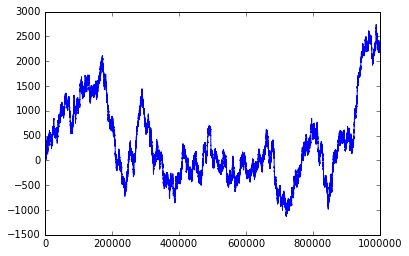

In [208]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(list(walk_slc))

### Make a fresh generator slice as in the above, and from it make a second generator that yields only the positive numbers in those first million.

In [219]:
mywalk = gen_fun_randwalk(0)  # Random walk generator that starts at 0
walk_slc = it.islice(mywalk, 0, 1000000)  # Slice of the random walk generator that yields first 1 mill values

pos_walk = (x for x in walk_slc if x > 0) 

Alternately use itertools:

In [220]:
mywalk = gen_fun_randwalk(0)  # Random walk generator that starts at 0
walk_slc = it.islice(mywalk, 0, 1000000)  # Slice of the random walk generator that yields first 1 mill values

pos_walk = it.filterfalse(lambda x: x<0, walk_slc)

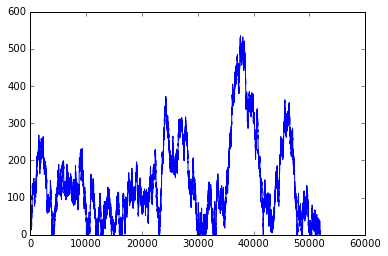

In [221]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(list(pos_walk))

### Make a generator that yields filenames that match a certain pattern.
See [this awesome collection of sys admin python snippets](http://www.dabeaz.com/generators/genfind.py). You should use the methods in the `os` (`walk` and `join`) and `fnmatch` (`filter`) modules for this. 

In [ ]:
import os
import fnmatch

def gen_file_find(filepat,top):
    for path, dirlist, filelist in os.walk(top):
        for name in fnmatch.filter(filelist,filepat):
            yield os.path.join(path,name)

### Simulating a fair coin  (see [Sahand Saba's post](http://sahandsaba.com/interview-question-groupon-probability.html))
Given an unfair coin which flips as heads with probability $0<p<1$ we can come up with an algorithm that flips a fair coin ($p=0.5$). Consider a pair of unfair coin flips, with the set of possible results being $\{HH,HT,TH,TT\}$. Both $HT$ and $TH$ have probability of exactly $p(1−p)$ which means we can map one to HEADS and one to TAILS to get a fair coin. Write a generator that generates fair flips, only using `numpy.random.binomial(n=1, p=p)` with an unfair coin.

In [230]:
from numpy.random import binomial

def flip_fair(p):
    outcomes = ["H", "T"]
    while True:
        x, y = binomial(n=1, p=p), binomial(n=1, p=p)  # Flip two unfair coins
        if x != y:  # proceed only if we are in the HT or TH case
            yield outcomes[x]  # half the time x will be 0, half it will be 1

In [231]:
flips = it.islice(flip_fair(0.1), 0, 10)
list(flips)

['H', 'T', 'H', 'T', 'T', 'T', 'H', 'H', 'T', 'H']

### Generator of Cartesian Coordiantes in $R^3$
I want a generator that yields the coordinates of points on a 3D grid (these will be 3-tuples). My $x$, $y$ and $z$ coordinates are each in the set $[0, 1, 2]$ (this is a small grid!). Take a look at the [itertools official docs](https://docs.python.org/3.7/library/itertools.html) to see if `it.product` can help with this. Bonus points if you can use `it.tee`.

In [247]:
x = iter([0, 1, 2])
xyz = it.tee(x, 3)
xyz

(<itertools._tee at 0x25df7042208>,
 <itertools._tee at 0x25df778ac08>)

In [248]:
pt_gen = it.product(*xyz)
next(pt_gen), next(pt_gen), next(pt_gen)

((0, 0, 0), (0, 0, 1), (0, 0, 2))